In [1]:
!apt-get update                                  # FFmpeg libs for PyAV
!apt-get install -y libavdevice-dev libavfilter-dev libavformat-dev libavcodec-dev
!pip install av                                 # PyAV (FFmpeg bindings)
!pip install transformers                       # Hugging Face Transformers
!pip install pytorchvideo                       # PyTorchVideo (video processor)
!pip install opencv-python-headless             # OpenCV I/O
!pip install shap                               # SHAP for explainability
!pip install torch                              # PyTorch backend
!pip install matplotlib                         # Plotting


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,665 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,926 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu

In [1]:
import cv2
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

In [2]:
# ─── 1) TAKE VIDEO AS INPUT ────────────────────────────────────────────────────
VIDEO_IN = "videoplayback.mp4"    # put your filename here


In [16]:
# ─── 2) EXTRACT FRAMES & SAMPLE TO 100 ───────────────────────────────────────
def extract_sampled_frames(path, size=(224, 224), num_frames=100):
    cap = cv2.VideoCapture(path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, total-1, num=num_frames, dtype=int)
    frames = []
    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i in idxs:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, size)
            frames.append(frame)
    cap.release()
    return frames

frames = extract_sampled_frames(VIDEO_IN, num_frames=100)

In [17]:
# Load CLIP model + processor (zero‐shot)
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_proc  = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Sentiment labels for zero‐shot
sentiment_labels = ["positive", "neutral", "negative"]
text_inputs = clip_proc(text=sentiment_labels, return_tensors="pt", padding=True).to(device)

In [18]:
# ─── 3) MODEL: ZERO‐SHOT SENTIMENT PER FRAME ──────────────────────────────────
def predict_frame_sentiment(frame):
    # returns raw scores for each label
    inputs = clip_proc(images=frame, return_tensors="pt").to(device)
    with torch.no_grad():
        img_emb = clip_model.get_image_features(**inputs)            # (1, dim)
        txt_emb = clip_model.get_text_features(**text_inputs)       # (3, dim)
    # cosine similarity
    scores = (img_emb @ txt_emb.T)[0] / (img_emb.norm() * txt_emb.norm(dim=1))
    probs  = torch.softmax(scores, dim=0).cpu().numpy()
    return dict(zip(sentiment_labels, probs))

# Compute original video probabilities by averaging frames
orig_frame_probs = np.array([list(predict_frame_sentiment(f).values()) for f in frames])
orig_probs = orig_frame_probs.mean(axis=0)
orig_dict  = dict(zip(sentiment_labels, orig_probs))
print("Original video sentiment:", orig_dict)

Original video sentiment: {'positive': np.float32(0.332312), 'neutral': np.float32(0.33203885), 'negative': np.float32(0.3356492)}


In [19]:
# ─── 4) SHAPLEY VALUES FRAME-BY-FRAME ─────────────────────────────────────────
# Use mean-pixel intensities as proxy features for each frame
frame_feats = np.stack([f.mean(axis=(0,1)).flatten() for f in frames])

# SHAP explainer: model_predict maps feats→score(“positive”) for simplicity
def model_predict(feat_array):
    # reconstruct gray frames from feature
    gray_frames = [(np.ones((100,100,3))*feat.mean()).astype(np.uint8) for feat in feat_array]
    # get probability of 'positive' label
    return np.array([predict_frame_sentiment(f)["positive"] for f in gray_frames])

explainer = shap.KernelExplainer(model_predict, frame_feats)
shap_vals = explainer.shap_values(frame_feats)  # array of shape (n_frames, feat_dim)

  0%|          | 0/100 [00:00<?, ?it/s]

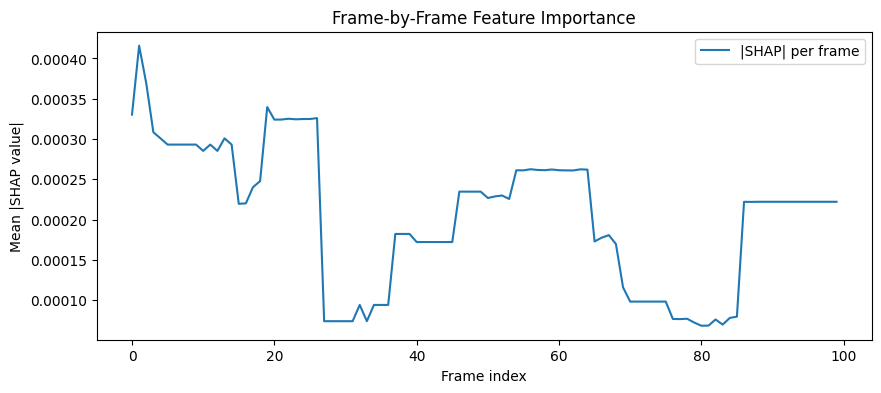

In [20]:
# ─── 5) PLOT SHAPLEY VALUE GRAPH ──────────────────────────────────────────────
mean_abs_shap = np.mean(np.abs(shap_vals), axis=1)  # one value per frame
plt.figure(figsize=(10,4))
plt.plot(mean_abs_shap, label="|SHAP| per frame")
plt.xlabel("Frame index")
plt.ylabel("Mean |SHAP value|")
plt.title("Frame-by-Frame Feature Importance")
plt.legend()
plt.show()

In [21]:
# ─── 6) COUNTERFACTUAL: FRAMES ALREADY EXTRACTED ───────────────────────────────
# ─── 7) NOISE: GAUSSIAN & SALT-AND-PEPPER ──────────────────────────────────────
def add_noise(frames, noise="gaussian", var=0.05):
    out = []
    for f in frames:
        f_norm = f.astype(np.float32) / 255.0
        if noise=="gaussian":
            g = np.random.normal(0, var**0.5, f_norm.shape)
            nf = np.clip(f_norm + g, 0,1)
        else:
            nf = f_norm.copy()
            rnd = np.random.rand(*f_norm.shape[:2])
            nf[rnd<var/2]       = 0
            nf[rnd>1-var/2]     = 1
        out.append((nf*255).astype(np.uint8))
    return out

cf_frames = add_noise(frames, noise="gaussian", var=0.05)


In [22]:
# ─── 7b) WRITE COUNTERFACTUAL VIDEO ────────────────────────────────────────────
def write_video(frames, out_file, fps=25):
    h,w = frames[0].shape[:2]
    writer = cv2.VideoWriter(out_file, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w,h))
    for f in frames:
        writer.write(cv2.cvtColor(f, cv2.COLOR_RGB2BGR))
    writer.release()

CF_OUT = "cf_video.mp4"
write_video(cf_frames, CF_OUT)

Counterfactual video sentiment: {'positive': np.float32(0.33000416), 'neutral': np.float32(0.33135873), 'negative': np.float32(0.3386372)}


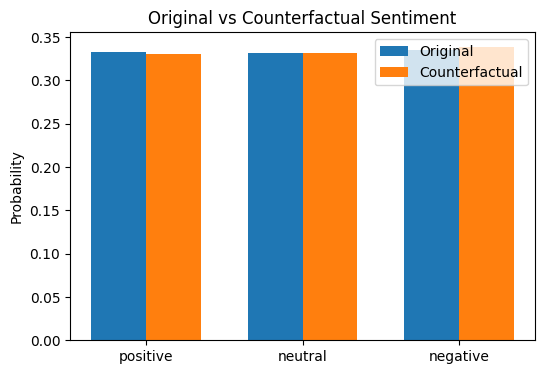

In [23]:
# ─── 8) COMPARE ORIGINAL vs COUNTERFACTUAL SENTIMENT ──────────────────────────
cf_frame_probs = np.array([list(predict_frame_sentiment(f).values()) for f in cf_frames])
cf_probs       = cf_frame_probs.mean(axis=0)
cf_dict        = dict(zip(sentiment_labels, cf_probs))
print("Counterfactual video sentiment:", cf_dict)

# Plot comparison
x = np.arange(len(sentiment_labels))
width = 0.35
plt.figure(figsize=(6,4))
plt.bar(x-width/2, orig_probs, width, label="Original")
plt.bar(x+width/2, cf_probs,   width, label="Counterfactual")
plt.xticks(x, sentiment_labels)
plt.ylabel("Probability")
plt.title("Original vs Counterfactual Sentiment")
plt.legend()
plt.show()

# Zoom

In [24]:
# Load OpenCV’s face detector
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

def get_counterfactual_frames(frames, mode="tight", margin=0.2):
    """
    mode="tight": crop exactly to detected face
    mode="zoom_out": expand crop by `margin` fraction to include more background
    """
    cf = []
    for f in frames:
        gray = cv2.cvtColor(f, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            x, y, w, h = faces[0]
            if mode == "tight":
                crop = f[y : y + h, x : x + w]
            else:  # zoom_out
                mx = int(w * margin)
                my = int(h * margin)
                x1 = max(0, x - mx)
                y1 = max(0, y - my)
                x2 = min(f.shape[1], x + w + mx)
                y2 = min(f.shape[0], y + h + my)
                crop = f[y1:y2, x1:x2]
        else:
            # no face detected, fallback to full frame
            crop = f
        # resize back to model input size
        cf.append(cv2.resize(crop, (224, 224)))
    return cf

# Generate your counterfactual frames:
# For a tight face crop:
cf_frames = get_counterfactual_frames(frames, mode="tight")

# Or, to zoom out and include more background:
# cf_frames = get_counterfactual_frames(frames, mode="zoom_out", margin=0.3)

In [25]:
# ── then write and predict exactly as before ─────────────────────────────────

CF_OUT = "cff_video.mp4"
write_video(cf_frames, CF_OUT)

cf_frame_probs = np.array([list(predict_frame_sentiment(f).values()) for f in cf_frames])
cf_probs = cf_frame_probs.mean(axis=0)
cf_dict = dict(zip(sentiment_labels, cf_probs))

print("Counterfactual (face-cropped) sentiment:", cf_dict)


Counterfactual (face-cropped) sentiment: {'positive': np.float32(0.33211532), 'neutral': np.float32(0.3327883), 'negative': np.float32(0.33509636)}


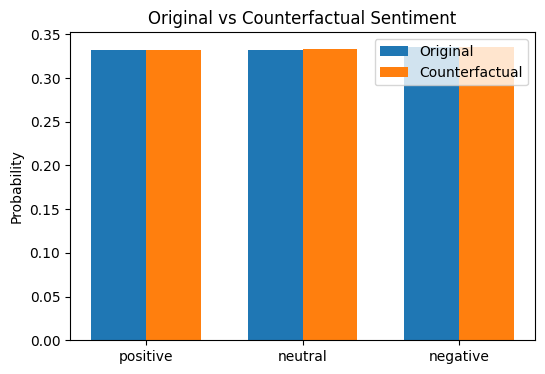

In [26]:
# Plot comparison
x = np.arange(len(sentiment_labels))
width = 0.35
plt.figure(figsize=(6, 4))
plt.bar(x - width / 2, orig_probs, width, label="Original")
plt.bar(x + width / 2, cf_probs, width, label="Counterfactual")
plt.xticks(x, sentiment_labels)
plt.ylabel("Probability")
plt.title("Original vs Counterfactual Sentiment")
plt.legend()
plt.show()

# Color Change

In [27]:
def change_clothing_color(frames, hue_shift=60):
    """
    Shifts the hue of the entire frame by `hue_shift` degrees in HSV space,
    which effectively remaps clothing (and everything else) to a new color.
    You can tweak hue_shift (0-180) to target different color changes.
    """
    cf = []
    for f in frames:
        # Convert to HSV
        hsv = cv2.cvtColor(f, cv2.COLOR_RGB2HSV).astype(np.uint16)
        h, s, v = cv2.split(hsv)

        # Shift hue channel
        h = (h + hue_shift) % 180

        # Merge and convert back to RGB
        hsv_shifted = cv2.merge([h.astype(np.uint8), s.astype(np.uint8), v.astype(np.uint8)])
        rgb_shifted = cv2.cvtColor(hsv_shifted, cv2.COLOR_HSV2RGB)
        cf.append(rgb_shifted)
    return cf

# Generate your counterfactual frames by shifting hue by 60° (e.g., blue→green)
cf_frames = change_clothing_color(frames, hue_shift=60)

In [29]:
# ── then write and predict exactly as before ───────────────────────────────────

CF_OUT = "cffc_video.mp4"
write_video(cf_frames, CF_OUT)

cf_frame_probs = np.array([list(predict_frame_sentiment(f).values()) for f in cf_frames])
cf_probs       = cf_frame_probs.mean(axis=0)
cf_dict        = dict(zip(sentiment_labels, cf_probs))

print("Counterfactual (clothing-color-changed) sentiment:", cf_dict)

Counterfactual (clothing-color-changed) sentiment: {'positive': np.float32(0.33173808), 'neutral': np.float32(0.33145618), 'negative': np.float32(0.33680564)}


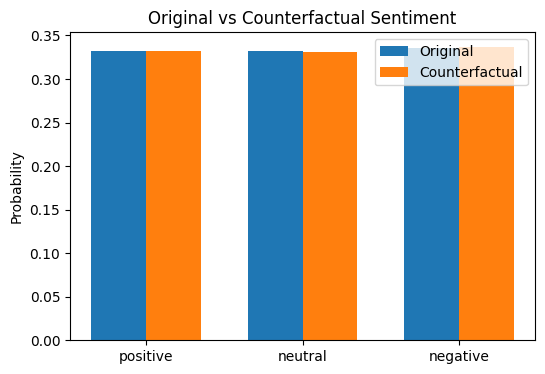

In [30]:
# Comparison plot (same as before)
x = np.arange(len(sentiment_labels))
width = 0.35
plt.figure(figsize=(6,4))
plt.bar(x-width/2, orig_probs, width, label="Original")
plt.bar(x+width/2, cf_probs,   width, label="Counterfactual")
plt.xticks(x, sentiment_labels)
plt.ylabel("Probability")
plt.title("Original vs Counterfactual Sentiment")
plt.legend()
plt.show()